In [ ]:
import matplotlib.lines as mlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import glob

sns.set_palette("colorblind")

warnings.filterwarnings("ignore")

In [ ]:
column_our_method = [
    "dataset",
    "method",
    "runtime",
    "mrr",
    "All_RecallAtSizeofGroundTruth",
    "All_F1Score",
]

column_other_methods = [
    "dataset",
    "matcher",
    "runtime",
    "MRR",
    "RecallAtSizeofGroundTruth",
    "F1Score",
]


def load_other_methods(path):
    df = pd.read_csv(path)

    df["runtime"] = df["runtime"].apply(lambda x: x / 1000)

    df["dataset"] = df["taskname"].apply(lambda x: x.split("/")[-1])

    df = df[column_other_methods]
    df.columns = column_our_method

    return df


def load_our_methods(path):
    df = pd.read_csv(path)

    df["dataset"] = df["source_table"].apply(lambda x: x.replace(".csv", "").lower())

    df = df[column_our_method]

    df = df[df["method"] != "ComaInst"]

    df["method"] = df["method"].apply(
        lambda x: x.replace("Magneto", "Magneto ") if "Magneto" in x else x
    )

    return df

In [ ]:
def fix_df(df):

    df = df.rename(columns={"All_RecallAtSizeofGroundTruth": "Recall@GT"})
    df = df.rename(columns={"All_F1Score": "F1"})
    df = df.rename(columns={"mrr": "MRR"})

    df = df.round(3)

    return df

In [ ]:
metrics = ["MRR", "Recall@GT"]


def plot(df, ax, metric):

    order = [
        "Magneto",
        "MagnetoGPT",
        "MagnetoFT",
        "MagnetoFTGPT",
        "Unicorn",
        "ISResMat",
        "Coma++",
        "Coma",
        "SimFlooding",
        "Jaccard",  # takes super long time and accuracy is super low, let's remove it
        "Distribution",
    ]

    x = sorted(df["dataset"].unique())

    magneto_methods = ["Magneto", "MagnetoFT", "MagnetoFTGPT", "MagnetoGPT"]
    other_methods = [m for m in order if m not in magneto_methods]

    # magneto_palette = sns.color_palette("blues", n_colors=len(magneto_methods))[::-1]

    # magneto_palette = sns.color_palette("Reds", n_colors=len(magneto_methods))

    magneto_palette = sns.color_palette("Reds", n_colors=len(magneto_methods))

    # Another colorblind-friendly palette for others
    other_palette = sns.color_palette("Blues", n_colors=len(other_methods))

    # Combine palettes into a dictionary
    palette = {
        method: color
        for method, color in zip(
            magneto_methods + other_methods, list(magneto_palette) + list(other_palette)
        )
    }

    sns.barplot(palette=palette, x="method", y=metric, data=df, ax=ax)

    # sns.boxplot(
    #     palette=sns.color_palette("Set2"),  # Use a better palette
    #     x='method',
    #     y=metric,
    #     data=df,
    #     ax=ax,
    #     showfliers=False,
    #     width=0.5
    # )
    # ax.set_title(f'{metric} by Dataset and Method')
    ax.set_xlabel(None)
    ax.set_ylabel(metric)
    ax.tick_params(axis="both", which="major", labelsize=14)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    ax.set_ylabel(metric, fontsize=16)

    ax.set_ylim(-0.01, 1.01)


def plot_bars_all(df, figsize=(9, 6), metric_order="MRR", save=None):

    # Calculate the mean MRR per method
    mean_mrr = df.groupby("method")[metric_order].mean().sort_values(ascending=False)
    df["method_rank"] = df["method"].map(mean_mrr.rank(ascending=False))
    df = df.sort_values(by="method_rank")

    fig, axis = plt.subplots(len(metrics), 1, figsize=figsize, sharex=True)

    for i, metric in enumerate(metrics):
        plot(df, axis[i], metric)

    sns.despine()

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches="tight")

In [ ]:
def analyze(df, metric, ascending=False):
    grouped = df.groupby("method")[metric].agg(["mean", "median", "min", "max", "std"])
    grouped = grouped.sort_values(by="mean", ascending=ascending)
    grouped = grouped.round(3)
    print("General stats")
    print(grouped)

    print("\n")

    grouped = df.groupby(["dataset", "method"])[metric].agg(
        ["mean", "median", "min", "max", "std"]
    )

    grouped = grouped.groupby(level=0).apply(
        lambda x: x.sort_values(by="mean", ascending=ascending)
    )

    grouped = grouped.round(3)
    print("Per dataset stats")
    print(grouped)

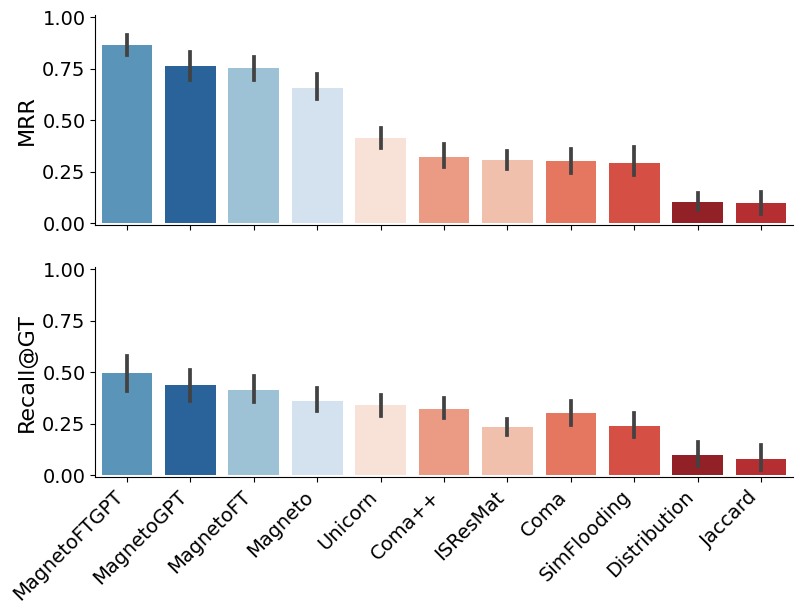

In [ ]:
main_path = "server_results/main_experiment_gdc/"
other_methods_path = main_path + "results_gdc_new.csv"
our_method_path = main_path + "results_gdc_magneto.csv"

df_other = load_other_methods(other_methods_path)
df_our = load_our_methods(our_method_path)

df = pd.concat([df_our, df_other])

df = fix_df(df)

# df = df[df['method'] != 'Jaccard']

df["method"] = df["method"].str.replace(" ", "")

# df.method.unique()

plot_bars_all(df, save="figures/main_experiment_gdc.pdf")

In [ ]:
analyze(df, "MRR")

General stats
               mean  median    min    max    std
method                                          
MagnetoFTGPT  0.866   0.864  0.750  0.967  0.083
MagnetoGPT    0.764   0.760  0.545  0.958  0.120
MagnetoFT     0.754   0.785  0.620  0.878  0.093
Magneto       0.659   0.627  0.530  0.842  0.104
Unicorn       0.413   0.410  0.278  0.523  0.085
Coma++        0.321   0.307  0.200  0.481  0.093
ISResMat      0.308   0.300  0.209  0.419  0.072
Coma          0.300   0.298  0.135  0.481  0.097
SimFlooding   0.295   0.302  0.178  0.542  0.107
Distribution  0.104   0.062  0.045  0.242  0.072
Jaccard       0.096   0.060  0.000  0.271  0.092


Per dataset stats
                               mean  median    min    max  std
dataset dataset method                                        
cao     cao     Unicorn       0.520   0.520  0.520  0.520  NaN
                ISResMat      0.329   0.329  0.329  0.329  NaN
                Coma          0.314   0.314  0.314  0.314  NaN
              

In [ ]:
analyze(df, "Recall@GT")

General stats
               mean  median    min    max    std
method                                          
MagnetoFTGPT  0.496   0.452  0.300  0.698  0.144
MagnetoGPT    0.437   0.428  0.281  0.667  0.136
MagnetoFT     0.414   0.424  0.297  0.630  0.106
Magneto       0.360   0.356  0.250  0.593  0.099
Unicorn       0.342   0.365  0.200  0.442  0.084
Coma++        0.323   0.315  0.200  0.481  0.086
Coma          0.300   0.306  0.135  0.481  0.093
SimFlooding   0.241   0.232  0.081  0.444  0.099
ISResMat      0.233   0.210  0.136  0.333  0.066
Distribution  0.100   0.076  0.000  0.300  0.103
Jaccard       0.077   0.042  0.000  0.350  0.106


Per dataset stats
                               mean  median    min    max  std
dataset dataset method                                        
cao     cao     Unicorn       0.442   0.442  0.442  0.442  NaN
                Coma          0.326   0.326  0.326  0.326  NaN
                Coma++        0.326   0.326  0.326  0.326  NaN
              

In [ ]:
analyze(df, "runtime", ascending=True)

General stats
                 mean   median      min       max      std
method                                                    
MagnetoFT       3.214    3.242    2.977     3.405    0.144
Jaccard        14.777    8.701    1.972    66.530   19.376
Magneto        15.458   15.221   13.168    20.145    2.098
Unicorn        46.818   42.556   19.745    75.951   16.207
Coma           89.217   43.608   14.282   446.896  129.550
Coma++         99.365   47.119   14.524   494.105  143.613
Distribution  117.174   77.793   37.406   430.347  115.725
MagnetoFTGPT  147.230  109.954   38.572   453.109  120.549
MagnetoGPT    154.143  117.404   59.345   444.293  114.763
SimFlooding   275.297  207.421   84.238   850.203  222.917
ISResMat      805.951  788.228  681.489  1120.345  122.596


Per dataset stats
                                 mean   median      min      max  std
dataset dataset method                                               
cao     cao     Jaccard        11.303   11.303   11.303   1

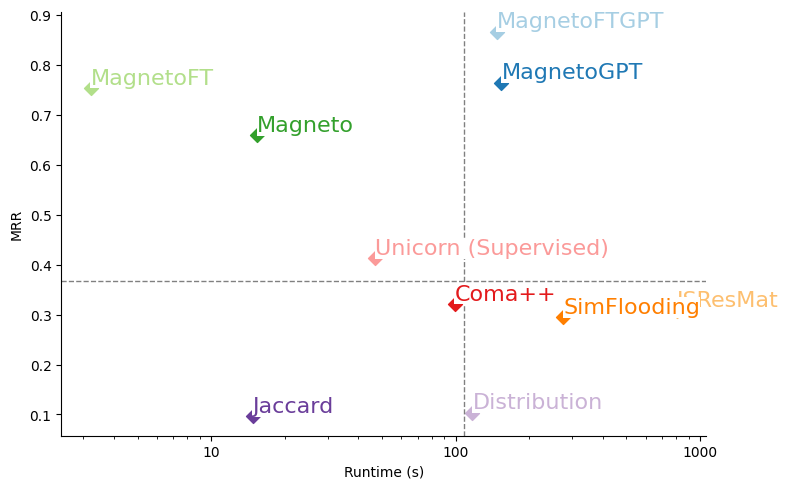

In [ ]:
def pareto_plot_mean(df, metrics, filename):

    fig, ax = plt.subplots(figsize=(8, 5))

    # markers = ['o', 's', 'D', '^', 'v']
    markers = ["D"]
    unique_matchers = df["matcher"].unique()
    marker_dict = {
        matcher: markers[i % len(markers)] for i, matcher in enumerate(unique_matchers)
    }

    palette = sns.color_palette("Paired", len(unique_matchers))

    right_anotations_matchers = ["IsResMat (Self-Supervised)"]

    for i, matcher in enumerate(unique_matchers):
        matcher_data = df[df["matcher"] == matcher]
        x = matcher_data[metrics[0]].values[0]
        y = matcher_data[metrics[1]].values[0]

        # Scatter plot for each matcher
        ax.scatter(
            x, y, label=matcher, color=palette[i], marker=marker_dict[matcher], s=50
        )

        if matcher in right_anotations_matchers:
            ax.text(
                x,
                y,
                matcher,
                fontsize=16,
                ha="right",
                va="bottom",
                color=palette[i],
                bbox=dict(facecolor="white", edgecolor="none", pad=0.3),
            )
        else:
            ax.text(
                x,
                y,
                matcher,
                fontsize=16,
                ha="left",
                va="bottom",
                color=palette[i],
                bbox=dict(facecolor="white", edgecolor="none", pad=0.3),
            )

    xlabel = metrics[0][0].upper() + metrics[0][1:]  # Capitalize the first letter
    ax.set_xlabel(xlabel)
    ax.set_ylabel(metrics[1].upper())

    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:g}"))
    ax.set_xticks([10, 100, 1000])

    #  quadrant lines based on median
    median_x = np.median(df[metrics[0]])
    median_y = np.median(df[metrics[1]])
    ax.axhline(median_y, color="grey", linestyle="--", linewidth=1)
    ax.axvline(median_x, color="grey", linestyle="--", linewidth=1)

    # Remove top and right borders
    sns.despine(ax=ax)

    ax.legend_.remove() if ax.get_legend() else None

    fig.savefig(filename + ".pdf", dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()


df["matcher"] = df["method"]
df["mrr"] = df["MRR"]

df = df.groupby("matcher")[["mrr", "runtime"]].mean().reset_index()
df = df[df["matcher"] != "Coma"]
df = df.sort_values(by="mrr", ascending=False)

df["matcher"] = df["matcher"].replace({"Unicorn": "Unicorn (Supervised)"})
# df['matcher'] = df['matcher'].replace({'ISResMat': 'IsResMat (Self-Supervised)'})


df.rename(columns={"runtime": "runtime (s)"}, inplace=True)

metrics = ["runtime (s)", "mrr"]
pareto_plot_mean(df, metrics, filename="run_mrr_mean_pareto_gdc")